# Architecture tweaking 

Let's change the architecture of our network.

In [1]:
from fastai.tabular.all import *
import numpy as np

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

Read the csv file into a dataframe

In [2]:
cwd = os.getcwd()
parent = os.path.dirname(cwd)
csv_path = os.path.join(parent, "data/", "master_results.csv")

In [3]:
df = pd.read_csv(csv_path, low_memory=False)
df.head(3)

,p_in,Re,Geometry
0,11.922400,532.38,channelStripRe
1,12.093420,760.11,channelStripRe
2,6.648019,1898.78,leftStripBendRe


In [4]:
df.Geometry = df.Geometry.transform(lambda x: x[:-2])

Let's look at the pressure column

In [5]:
df['p_in'].describe()

count    6.400000e+02
mean     9.761427e+20
std      2.469467e+22
min      2.455772e-01
25%      9.476800e-01
50%      2.528182e+00
75%      7.338899e+00
max      6.247313e+23
Name: p_in, dtype: float64

From the values above we can see that some of the flow cases have not been solved properly by openFOAM. Let's drop all of the unnatural values.

In [6]:
df['p_in'] = np.where(df['p_in'] > 100, False, df['p_in'])
labels = df['p_in'] != False
df = df.loc[labels, :]
df.shape

(625, 3)

In [7]:
df['p_in'].describe()

count    625.000000
mean       5.198978
std        8.167323
min        0.245577
25%        0.926666
50%        2.519571
75%        6.740670
max       88.850320
Name: p_in, dtype: float64

In [8]:
df['p_in'] = np.log1p(df['p_in'])

In [9]:
df['p_in'].describe()

count    625.000000
mean       1.382942
std        0.874236
min        0.219599
25%        0.655791
50%        1.258339
75%        2.046488
max        4.498145
Name: p_in, dtype: float64

In [10]:
df.Geometry.unique()

array(['channelStrip', 'leftStripBend', 'rightStripBend', 'forwardStep',
       'backwardStep', 'narrowEndBend', 'bend', 'channel'], dtype=object)

In [11]:
cats_to_unknown = ['narrowEndBend', 'channel', 'channelStrip']
df.Geometry = df.Geometry.transform(lambda x: x if x not in cats_to_unknown else 'unknown')
df.Geometry

0             unknown
1             unknown
2       leftStripBend
3      rightStripBend
4         forwardStep
            ...      
634       forwardStep
636     leftStripBend
637           unknown
638           unknown
639           unknown
Name: Geometry, Length: 625, dtype: object

In [12]:
# Create derived features from your existing variables
df['Re_log'] = np.log1p(df['Re'])  # Log transform
df['Re_squared'] = df['Re'] ** 2
df['Re_sqrt'] = np.sqrt(df['Re'])
df['Re_binned'] = pd.cut(df['Re'], bins=20, labels=False)  # Discretize

# Physics-inspired features 
df['Re_inverse'] = 1 / (df['Re'] + 1e-6)
df['Re_range_normalized'] = (df['Re'] - df['Re'].min()) / (df['Re'].max() - df['Re'].min())

# Update continuous variables
cont = ['Re', 'Re_log', 'Re_squared', 'Re_sqrt', 'Re_inverse', 'Re_range_normalized']

In [13]:
procs = [Categorify,  Normalize]
cat = ["Geometry", "Re_binned"]
dep_var = "p_in"

We will randomly split the dataset into a training and validation sets.

In [14]:
splits = RandomSplitter()(df)
tabular_set = TabularPandas(
    df=df,
    procs=procs,
    cat_names=cat,
    cont_names=cont,
    y_names=dep_var,
    y_block=RegressionBlock(),
    splits=splits
)

In [15]:
# Create DataLoaders
dls = tabular_set.dataloaders(bs=16)  # Batch size 64

In [16]:
# Strategy 1: Wider networks (more neurons per layer)
learn_wide = tabular_learner(
    dls,
    layers=[500, 300, 100],  # Wider layers
    metrics=[rmse, mae],
)

In [17]:
# Train for a few epochs
learn_wide.fit(8, lr=0.1)  # Very small LR to test

epoch,train_loss,valid_loss,_rmse,mae,time
0,2.731605,0.610249,0.781184,0.592121,00:00
1,1.556021,0.403473,0.635195,0.484462,00:00
2,1.165535,0.489960,0.699971,0.556245,00:00
3,0.931550,0.670243,0.818683,0.676474,00:00
4,0.761835,0.328799,0.573410,0.369864,00:00
5,0.634675,3.551129,1.884444,0.634284,00:00
6,0.615989,0.655349,0.809536,0.519481,00:00
7,0.554431,0.378104,0.614902,0.431697,00:00


In [4]:
learn_wide = load_pickle('models/wideModel.pkl')

In [7]:
preds, targets = learn_wide.get_preds(dl=learn_wide.dls.valid)


In [8]:
preds = preds.numpy().flatten()
targets = targets.numpy().flatten()

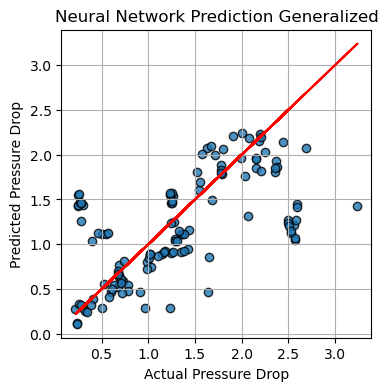

In [10]:
plt.figure(figsize=(4,4))
plt.scatter(targets, preds, alpha=0.8, edgecolors='black')
plt.plot(targets, targets, color='red')
plt.xlabel("Actual Pressure Drop")
plt.ylabel("Predicted Pressure Drop")
plt.title("Neural Network Prediction Generalized")
plt.grid()
plt.show()

In [21]:
# Strategy 2: Deeper networks (more layers)
learn_deep = tabular_learner(
    dls,
    layers=[200, 200, 200, 100, 50],  # More layers
    metrics=[rmse, mae],
)

In [22]:
# Train for a few epochs
learn_deep.fit(3, lr=0.1)  # Very small LR to test

epoch,train_loss,valid_loss,_rmse,mae,time
0,1.364370,0.440483,0.663689,0.534559,00:00
1,0.965362,0.382305,0.618308,0.470953,00:00
2,0.813316,0.404307,0.635851,0.480917,00:00


In [23]:
preds, targets = learn_deep.get_preds(dl=dls.valid)

In [24]:
preds = preds.numpy().flatten()
targets = targets.numpy().flatten()

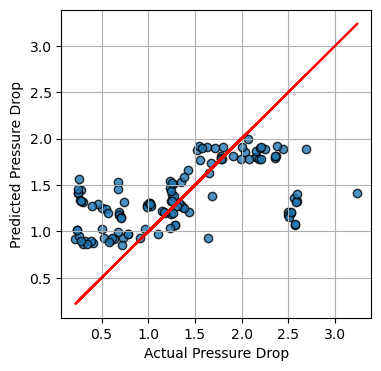

In [25]:
plt.figure(figsize=(4,4))
plt.scatter(targets, preds, alpha=0.8, edgecolors='black')
plt.plot(targets, targets, color='red')
plt.xlabel("Actual Pressure Drop")
plt.ylabel("Predicted Pressure Drop")
plt.grid()
plt.show()

In [28]:
# Strategy 3: Skip connections (using ps parameter)
learn_skip = tabular_learner(
    dls,
    layers=[400, 200, 100],
    config=tabular_config(ps=[0.1, 0.1, 0.05]),  # Dropout for each layer
    metrics=[rmse, mae],
)

In [29]:
# Train for a few epochs
learn_skip.fit(8, lr=0.1)  # Very small LR to test

epoch,train_loss,valid_loss,_rmse,mae,time
0,2.486198,0.962970,0.981310,0.799723,00:00
1,1.486161,0.922861,0.960657,0.817137,00:00
2,1.155454,0.374683,0.612114,0.442115,00:00
3,0.886263,0.728454,0.853495,0.749035,00:00
4,0.768687,0.363783,0.603144,0.440095,00:00
5,0.675570,0.428102,0.654295,0.539958,00:00
6,0.585156,0.335590,0.579302,0.380764,00:00
7,0.555663,0.412826,0.642515,0.461688,00:00


In [30]:
preds, targets = learn_skip.get_preds(dl=dls.valid)

In [31]:
preds = preds.numpy().flatten()
targets = targets.numpy().flatten()

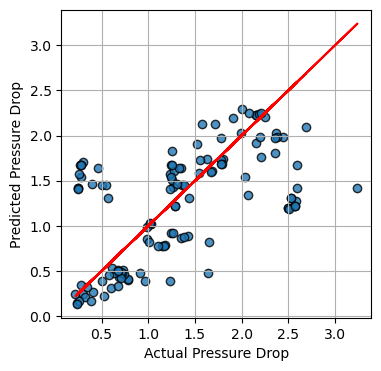

In [32]:
plt.figure(figsize=(4,4))
plt.scatter(targets, preds, alpha=0.8, edgecolors='black')
plt.plot(targets, targets, color='red')
plt.xlabel("Actual Pressure Drop")
plt.ylabel("Predicted Pressure Drop")
plt.grid()
plt.show()

In [33]:
save_pickle('models/wideModel.pkl', learn_wide)
save_pickle('models/deepModel.pkl', learn_deep)
save_pickle('models/skipModel.pkl', learn_skip)